In [ ]:
print("Start")

Start


##Import modules

In [ ]:
import numpy as np
import pandas as pd
import re
import os
import string
import matplotlib.pyplot as plt
import nltk
import jiwer
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
! pip install -q scikit-plot
import scikitplot as skplt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##Load data

In [ ]:
#Original data
df_orig = pd.read_csv('/content/drive/MyDrive/Medical Speech, Transcription, and Intent/data/overview-of-recordings.csv')
df_orig.head()

,audio_clipping,audio_clipping:confidence,background_noise_audible,background_noise_audible:confidence,overall_quality_of_the_audio,quiet_speaker,quiet_speaker:confidence,speaker_id,file_download,file_name,phrase,prompt,writer_id
0,no_clipping,1.0000,light_noise,1.0000,3.33,audible_speaker,1.0,43453425,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43453425_58166571.wav,When I remember her I feel down,Emotional pain,21665495
1,light_clipping,0.6803,no_noise,0.6803,3.33,audible_speaker,1.0,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43719934_43347848.wav,When I carry heavy things I feel like breaking...,Hair falling out,44088126
2,no_clipping,1.0000,no_noise,0.6655,3.33,audible_speaker,1.0,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43719934_53187202.wav,there is too much pain when i move my arm,Heart hurts,44292353
3,no_clipping,1.0000,light_noise,1.0000,3.33,audible_speaker,1.0,31349958,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_31349958_55816195.wav,My son had his lip pierced and it is swollen a...,Infected wound,43755034
4,no_clipping,1.0000,no_noise,1.0000,4.67,audible_speaker,1.0,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43719934_82524191.wav,My muscles in my lower back are aching,Infected wound,21665495


In [ ]:
#audio2text data
df = pd.read_csv('/content/drive/MyDrive/Medical Speech, Transcription, and Intent/data/merged_data.csv')
df.head()

,file_name,converted_phrase,phrase,label
0,1249120_44246595_105657955.wav,I have a feeling like my whole body is complai...,I have a feeling like my whole body is complai...,Joint pain
1,1249120_44246595_107248522.wav,I noticed an important increase in my vision w...,I noticed an important decrease in my vision w...,Blurry vision
2,1249120_44246595_101823153.wav,I feel pain in my right shoulder after the ten...,I feel pain in my right shoulder after the ten...,Injury from sports
3,1249120_44246595_89466082.wav,I often get a stomach ache after I eat I haven...,I often get a stomach ache after I eat. I hav...,Stomach ache
4,1249120_44246595_92462780.wav,he was discovered to have an open wound,He was discovered to have an open wound.,Open wound


In [ ]:
#How many audio files were not transcibed/recognized properly
df_orig.shape[0] - df.shape[0]

377

In [ ]:
df.shape

(6284, 4)

In [ ]:
df.columns

Index(['file_name', 'converted_phrase', 'phrase', 'label'], dtype='object')

In [ ]:
df.isnull().sum()

file_name           0
converted_phrase    0
phrase              0
label               0
dtype: int64

##Text error

In [ ]:
df.shape

(6284, 4)

In [ ]:
df["phrase"] = df["phrase"].str.lower()
df["converted_phrase"] = df["converted_phrase"].str.lower()

In [ ]:
df.head()

,file_name,converted_phrase,phrase,label
0,1249120_44246595_105657955.wav,i have a feeling like my whole body is complai...,i have a feeling like my whole body is complai...,Joint pain
1,1249120_44246595_107248522.wav,i noticed an important increase in my vision w...,i noticed an important decrease in my vision w...,Blurry vision
2,1249120_44246595_101823153.wav,i feel pain in my right shoulder after the ten...,i feel pain in my right shoulder after the ten...,Injury from sports
3,1249120_44246595_89466082.wav,i often get a stomach ache after i eat i haven...,i often get a stomach ache after i eat. i hav...,Stomach ache
4,1249120_44246595_92462780.wav,he was discovered to have an open wound,he was discovered to have an open wound.,Open wound


In [ ]:
!pip install -q jiwer

In [ ]:
#Word error rate
phrase_list = df['phrase'].tolist()
converted_phrase_list = df['converted_phrase'].tolist()

wer = jiwer.wer(phrase_list, converted_phrase_list)
cer = jiwer.cer(phrase_list, converted_phrase_list)

print(f"Word Error Rate: {100*wer:.2f}%")
print(f"Char Error Rate: {100*cer:.2f}%")

Word Error Rate: 17.31%
Char Error Rate: 8.77%


##EDA

In [ ]:
x = df["converted_phrase"]
y = df["label"]

In [ ]:
print("Different numbers of Symptoms(labels):", y.nunique())

Different numbers of Symptoms(labels): 25


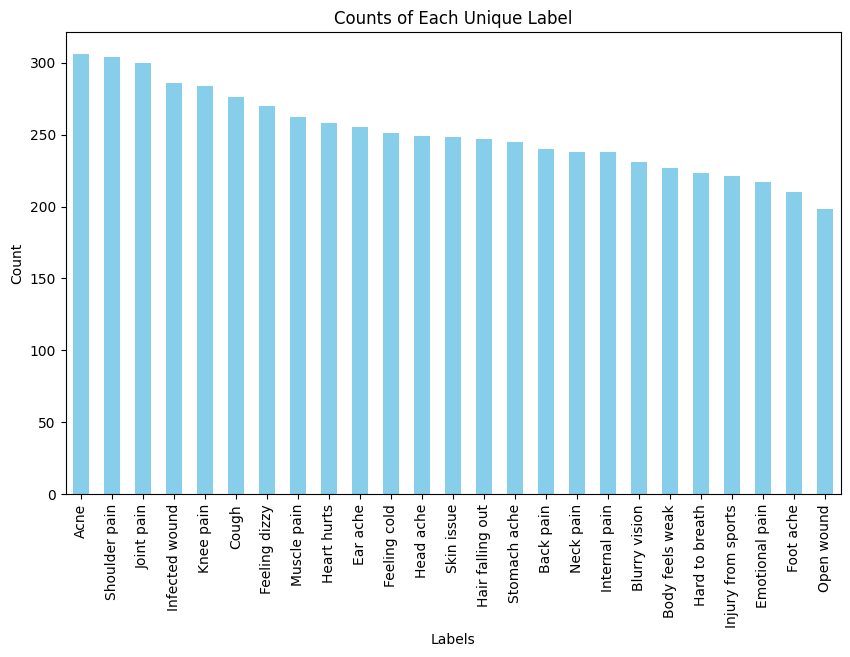

In [ ]:
label_counts = y.value_counts()

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Counts of Each Unique Label')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [ ]:
word_count = [len(sent.split(' ')) for sent in x]
word_count = pd.Series(word_count)
word_count.describe()

count    6284.000000
mean       10.270210
std         4.881358
min         1.000000
25%         7.000000
50%         9.000000
75%        13.000000
max        31.000000
dtype: float64

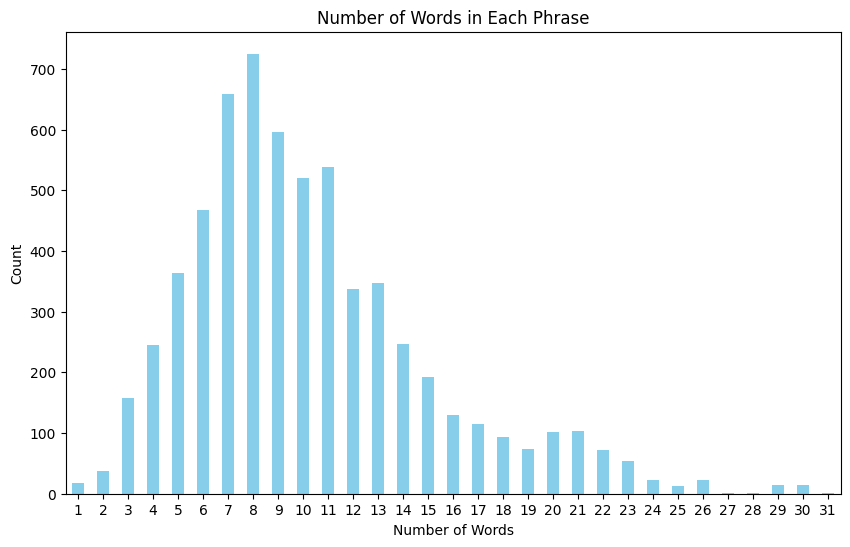

In [ ]:
plt.figure(figsize=(10, 6))
word_count.value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Number of Words in Each Phrase')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

##Preprocess

In [ ]:
def clean_data(doc):
  #lowering
  doc = doc.lower()
  #remove URL
  url = r"http\S+|https\S+|www\S+"
  doc = re.sub(url, '', doc)
  #remove punctuation
  punct = ".,:;'\"()[]{}!@#$%^&*-_=+?<>`~"
  strng = [chr for chr in doc if chr not in punct]
  doc = ''.join(strng)
  #remove stopwords
  words = doc.split(' ')
  stop_words = set(stopwords.words('english'))
  words = [word for word in words if(word!='' and word not in stop_words)]
  #lemmatization
  lemmatizer = nltk.stem.WordNetLemmatizer()
  words = [lemmatizer.lemmatize(word) for word in words]
  doc = ' '.join(words)
  return doc

In [ ]:
x[2]

'i feel pain in my right shoulder after the tennis match'

In [ ]:
clean_data(x[2])

'feel pain right shoulder tennis match'

In [ ]:
x = x.apply(clean_data)

In [ ]:
word_count = [len(sent.split(' ')) for sent in x]
word_count = pd.Series(word_count)
word_count.describe()

count    6284.000000
mean        4.981063
std         2.381649
min         1.000000
25%         3.000000
50%         5.000000
75%         6.000000
max        14.000000
dtype: float64

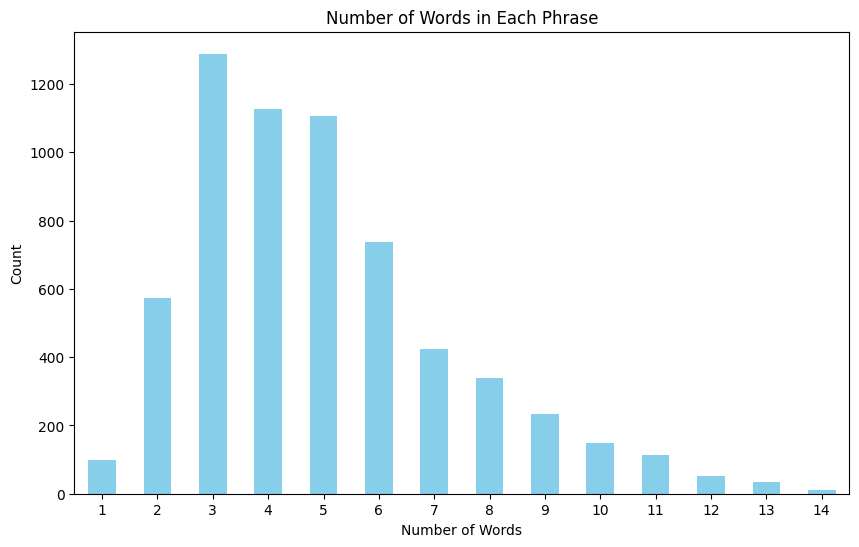

In [ ]:
plt.figure(figsize=(10, 6))
word_count.value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Number of Words in Each Phrase')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [ ]:
x.head(5)

0                  feeling like whole body complaining
1    noticed important increase vision try look thi...
2                feel pain right shoulder tennis match
3    often get stomach ache eat havent able pinpoin...
4                                discovered open wound
Name: converted_phrase, dtype: object

In [ ]:
type(x)

pandas.core.series.Series

In [ ]:
type(y)

pandas.core.series.Series

##Model

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
vectorizers = {
    'CountVectorizer': CountVectorizer(),
    'TfidfVectorizer': TfidfVectorizer()
}

In [ ]:
models = {
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SVC': SVC(),
}

In [ ]:
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

In [ ]:
for vectorizer_name, vectorizer in vectorizers.items():
  x_vect = vectorizer.fit_transform(x)
  x_train, x_test, y_train, y_test = train_test_split(x_vect, y, test_size=0.2, stratify=y, random_state=42)
  for model_name, model in models.items():
    scores = cross_val_score(model, x_vect, y, cv=kf)
    mean_accuracy = scores.mean()
    print(f"Vectorizer:{vectorizer_name}, Model:{model_name} \nAccuracy: {100*mean_accuracy:.4f}")

Vectorizer:CountVectorizer, Model:DecisionTreeClassifier 
Accuracy: 90.3407
Vectorizer:CountVectorizer, Model:RandomForestClassifier 
Accuracy: 93.2847
Vectorizer:CountVectorizer, Model:KNeighborsClassifier 
Accuracy: 92.7435
Vectorizer:CountVectorizer, Model:SVC 
Accuracy: 93.2210
Vectorizer:TfidfVectorizer, Model:DecisionTreeClassifier 
Accuracy: 89.5290
Vectorizer:TfidfVectorizer, Model:RandomForestClassifier 
Accuracy: 93.4756
Vectorizer:TfidfVectorizer, Model:KNeighborsClassifier 
Accuracy: 90.9929
Vectorizer:TfidfVectorizer, Model:SVC 
Accuracy: 94.1122


In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# rfc = RandomForestClassifier(random_state=42)

# grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy')
# grid_search.fit(x_train, y_train)

# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

In [ ]:
# model = RandomForestClassifier(random_state=42, **best_params)
# model.fit(x_train, y_train)
# y_pred = model.predict(x_test)
# test_accuracy = accuracy_score(y_test, y_pred)
# print(f"Test accuracy: {100*test_accuracy:.4f}")

In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {100*test_accuracy:.4f}")

Test accuracy: 94.2721


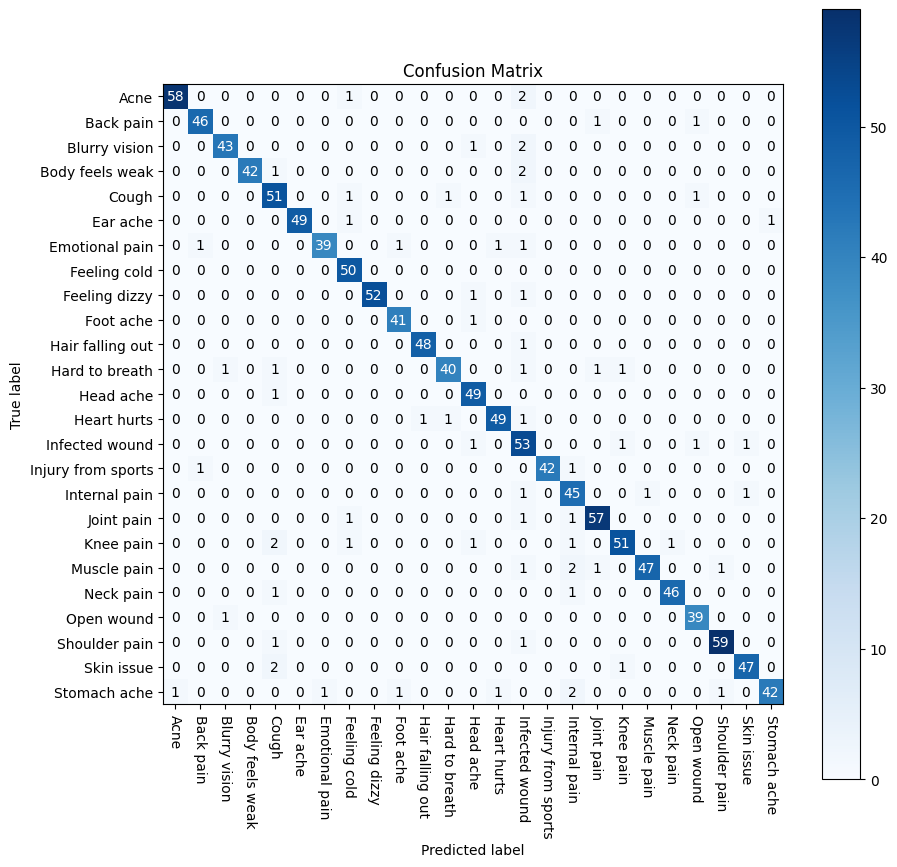

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(10,10))

plt.xticks(rotation=270)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

              Acne       0.98      0.95      0.97        61
         Back pain       0.96      0.96      0.96        48
     Blurry vision       0.96      0.93      0.95        46
   Body feels weak       1.00      0.93      0.97        45
             Cough       0.85      0.93      0.89        55
          Ear ache       1.00      0.96      0.98        51
    Emotional pain       0.97      0.91      0.94        43
      Feeling cold       0.91      1.00      0.95        50
     Feeling dizzy       1.00      0.96      0.98        54
         Foot ache       0.95      0.98      0.96        42
  Hair falling out       0.98      0.98      0.98        49
    Hard to breath       0.95      0.89      0.92        45
         Head ache       0.91      0.98      0.94        50
       Heart hurts       0.96      0.94      0.95        52
    Infected wound       0.77      0.93      0.84        57
Injury from sports       1.00      0.95